In [3]:
!pip install torcheval

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torcheval.metrics.functional import multiclass_f1_score
from torchvision import datasets, transforms, models
from matplotlib import pyplot as plt
import numpy as np
from torchsummary import summary

is_cuda = torch.cuda.is_available()
print(is_cuda)
device = torch.device('cuda' if is_cuda else 'cpu')
print('Current cuda device is', device)

True
Current cuda device is cuda


In [4]:
!nvcc --version
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Torch version:2.1.0+cu118
cuda version: 11.8
cudnn version:8700


In [5]:
train_data = datasets.CIFAR10(root = './data/02/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())

test_data = datasets.CIFAR10(root = './data/02/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_data = datasets.CIFAR10('./data', download=True, train=True,
                              transform=transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
)
# Download and load the test data
test_data = datasets.CIFAR10('./data', download=True, train=False,
                              transform=transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
)

print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

Files already downloaded and verified
Files already downloaded and verified
number of training data :  50000
number of test data :  10000
Files already downloaded and verified
Files already downloaded and verified
number of training data :  50000
number of test data :  10000


- 원래는 32x32x3인데 224x224로 transforms 함수 써서 바꿈

torch.Size([224, 224, 3])


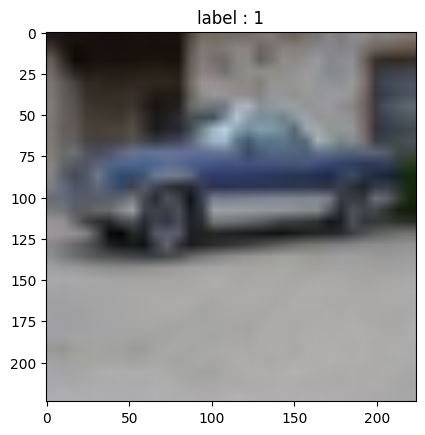

In [6]:
image, label = train_data[10000]
image = image.permute(1, 2, 0)
print(image.shape)

plt.figure()
plt.imshow(image.numpy())
plt.title('label : %s' % label)
plt.show()

#plt.imshow(image).squeeze().numpy(), cmap='rgb')
#plt.show()

In [10]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = batch_size, shuffle = True)
test_loaderA = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = batch_size, shuffle = True)
first_batch = train_loader.__iter__().__next__()

In [11]:
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 500
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([100, 3, 224, 224])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([100])


In [11]:
resnet18_pretrained = models.resnet18(pretrained=True)
resnet18_pretrained.to("cuda")
# summary(resnet18_pretrained, input_size=(3, 224, 224))
for param in resnet18_pretrained.parameters():
    param.requires_grad = True  # Weights Freeze

for param in resnet18_pretrained.parameters():
    param.requires_grad = True

num_ftrs = resnet18_pretrained.fc.in_features
print(num_ftrs) # ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수
resnet18_pretrained.fc = nn.Linear(num_ftrs, 10)
resnet18_pretrained.sf = nn.Softmax(dim=1)
resnet18_pretrained = resnet18_pretrained.to(device)

#print(resnet18_pretrained)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=(1,1))   #224*224   # (in-channe, out-channel,  , strinding)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=(1,1))  #same
        self.conv3 = nn.Conv2d(32, 100, 3, 1, padding=(1,1)) #same
        self.dropout = nn.Dropout2d(0.25)
        # (입력 뉴런, 출력 뉴런)
        self.fc1 = nn.Linear(313600, 1000)    # 56*56*100 = 313600
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 반절 줄어
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 반절 줄어
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


model = CNN().to(device)
#print(model)

learning_rate = 0.001
optimizer = optim.Adam(resnet18_pretrained.parameters(), lr = learning_rate)
optimizer0 = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

```python
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
```

위에를 통틀어서 convolution이라고 하기도 함

In [13]:
resnet18_pretrained.train()
#model.train()

epoch_num = 2
i = 1
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = resnet18_pretrained(data)
        #output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print("Train Step :{}  {}\tLoss : {:3f}".format(epoch, i, loss.item()))
        i += 1

Train Step :0  100	Loss : 0.631524
Train Step :0  200	Loss : 0.641870
Train Step :0  300	Loss : 0.540941
Train Step :0  400	Loss : 0.372230
Train Step :0  500	Loss : 0.451633
Train Step :1  600	Loss : 0.276236
Train Step :1  700	Loss : 0.277767
Train Step :1  800	Loss : 0.369319
Train Step :1  900	Loss : 0.365539
Train Step :1  1000	Loss : 0.372553


- loss값이 strictly하게 감소는 안하지만.. 경양??적으로 감소함 (왔다 갔다 하면서 감소)

- 

In [18]:
resnet18_pretrained.eval()
correct = 0

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = resnet18_pretrained(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('Test set Accuracy : {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

f1 = 0
ip = 0
resnet18_pretrained.eval()
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = resnet18_pretrained(data)
    prediction = output.data.max(1)[1]
    ip += 1
    f1 += multiclass_f1_score(prediction, target, num_classes=10, average='micro')

print(f1/ip)

tensor(0.8919, device='cuda:0')
